In [30]:
# read j3 wrf ts files

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils import Tower
from dateutil import parser
import datetime
from mmctools.plotting import TaylorDiagram
import matplotlib.colors as mcolors

obs_dir = '/projects/mmcpnnl/sgp_obs/'
wrf_runs_dir = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'
nb_dir = !pwd

# time step of wrf runs
wrf_dt = 6

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

# obs
dlprofwind_ncs = obs_dir+'sgpdlprofwind4newsC1.c1/*.nc'
dlprofwstats_ncs = obs_dir+'sgpdlprofwstats4newsC1.c1/*.nc'

dlprofwind = xr.open_mfdataset(dlprofwind_ncs)
dlprofwstats = xr.open_mfdataset(dlprofwstats_ncs)

# according to Rob Newsom, lidar data taken < 100 m need to be thrown out
toss_wp_data_below_height = 100

# vertical profile plot top height threshold
profile_hgt_thres = 2000

# plotting variables
dlprofwind_dict = {'ws': ['wind_speed', r'ws (m s$^{-1}$)'], 'wd': ['wind_direction', 'wd (deg)']}
dlprofwstats_dict = {'w': ['w', r'w (m s$^{-1}$)']}

In [2]:
data_dir_df

,2018-08-05,2018-09-01
mynn,0805m,0901m
edmf,0805m-d3-les,0901e
wrf_start,8/4/18 12:00,8/31/18 12:00


In [9]:
data_dir_df['2018-08-05']['wrf_start']

'8/4/18 12:00'

In [22]:
wrf_height_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 116.91344, 142.8942, 168.87497, 194.85573, 220.83649, 246.81725, 272.798, 298.77878, 324.75955, 350, 350.7403, 376.72107, 402.70184, 428.6826, 450, 454.66336, 480.64413, 506.62488, 532.60565, 550, 558.5864, 584.5672, 610.5479, 636.5287, 650, 662.50946, 688.49023, 714.471, 740.4518, 750, 766.4325, 792.41327, 818.39404, 844.3748, 850, 870.3556, 896.33636, 922.3171, 948.29785, 950, 974.2786, 1000.2594, 1026.2401, 1050, 1052.221, 1078.2017, 1104.1825, 1130.1632, 1150, 1156.1439, 1182.1248, 1208.1055, 1234.0863, 1250, 1260.067, 1286.0477, 1312.0286, 1338.0093, 1350, 1363.9901, 1389.9708, 1415.9517, 1441.9324, 1450, 1467.9131, 1493.8939, 1519.8746, 1545.8555, 1550, 1571.8362, 1597.8169, 1623.7977, 1649.7784, 1650, 1675.7593, 1701.74, 1727.7208, 1750, 1753.7015, 1779.6823, 1805.6631, 1831.6438, 1850, 1857.6246, 1883.6053, 1909.586, 1935.5669, 1950, 1961.5476, 1987.5284, 2013.5092, 2039.49, 2050, 2065.4707, 2091.4514, 2117.4321, 2143.413, 2150, 2169.3938, 2195.3745, 2221.3552, 2247.336, 2250, 2273.317, 2299.2976, 2325.2783, 2350, 2351.259, 2377.2397, 2403.2207, 2429.2014, 2450, 2455.1821, 2481.1628, 2507.1436, 2533.1245, 2550, 2559.1052, 2585.086, 2611.0667, 2637.0476, 2650, 2663.0283, 2689.009, 2714.9897, 2740.9705, 2750, 2766.9514, 2792.9321, 2818.9128, 2844.8936, 2850, 2870.8743, 2896.8552, 2922.836, 2948.8167, 2950, 2974.7974, 3000.778, 3026.759, 3052.7397, 3078.7205, 3104.7012, 3130.682, 3156.6628, 3182.6436, 3208.6243, 3234.605, 3260.5857, 3286.5667, 3312.5474, 3338.528, 3364.5088, 3390.4897, 3416.4705, 3442.4512, 3468.432, 3494.4126, 3520.3936, 3546.3743, 3572.355, 3598.3357, 3624.3164, 3650.2974, 3676.278, 3702.2588, 3728.2395, 3754.2202, 3780.2012, 3806.182, 3832.1626, 3858.1433, 3884.124, 3910.105, 3936.0857, 3962.0664, 3988.047, 4014.0278, 4040.0088, 4065.9895, 4091.9702, 4117.951, 4143.9316, 4169.9126, 4195.893, 4221.874, 4247.855, 4273.8354, 4299.8164, 4325.797]


In [28]:
date_col = data_dir_df['2018-08-05']

wrf_edmf_dir = wrf_runs_dir+date_col['edmf']+'/'
c1_edmf_file_path = wrf_edmf_dir+'z.c1.d03'
edmf_tower = Tower(c1_edmf_file_path)

wrf_edmf_ds = read_tower_to_ds(edmf_tower, '8/4/18 12:00', 2, wrf_height_list)

# plot_wp_ts_profile('2018-08-05', 'edmf', wrf_edmf_ds, obs_ds, wrf_var, var[0], var[1], time_freq)

In [33]:
wrf_edmf_ds

<xarray.Dataset>
Dimensions:   (datetime: 21600, height: 200, station: 1)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-05T12:00:02 ... 2018-08-06
  * height    (height) float64 10.0 20.0 30.0 ... 4.274e+03 4.3e+03 4.326e+03
  * station   (station) <U4 'z.c1'
Data variables:
    v         (datetime, height, station) float64 4.063 5.015 ... -0.9444
    w         (datetime, height, station) float64 -0.006824 -0.01998 ... 1.228
    pr        (datetime, height, station) float64 9.786e+04 ... 5.917e+04
    qv        (datetime, height, station) float64 0.01513 0.01512 ... 0.002571
    theta     (datetime, height, station) float64 298.8 299.0 ... 318.5 318.6
    u         (datetime, height, station) float64 0.07981 0.1898 ... 3.088 3.051
    i         (station) int64 114
    j         (station) int64 210
    lat       (station) float64 36.6
    lon       (station) float64 -97.48
    zsurface  (station) float64 311.2
    t2        (datetime, station) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0
    q2        (datetime, station) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0
    u10       (datetime, station) float64 0.3348 0.3348 0.3348 ... 0.6072 0.6072
    v10       (datetime, station) float64 87.15 87.15 87.14 ... 73.29 73.29 73.3
    psfc      (datetime, station) float64 22.12 22.12 22.12 ... 234.8 234.8
    lwd       (datetime, station) float64 102.1 102.1 102.1 ... 569.8 569.8
    swd       (datetime, station) float64 17.06 17.06 17.06 ... 69.25 69.25
    hfx       (datetime, station) float64 22.12 22.12 22.12 ... 234.8 234.8
    lfx       (datetime, station) float64 102.1 102.1 102.1 ... 569.8 569.8
    tsk       (datetime, station) float64 15.68 16.05 16.11 ... 239.0 238.9
    slttop    (datetime, station) float64 125.9 126.2 126.4 ... 566.0 565.8
    rainc     (datetime, station) float64 9.632 9.975 10.02 ... 75.37 75.35
    rainnc    (datetime, station) float64 15.71 16.08 16.15 ... 239.1 239.0
    clw       (datetime, station) float64 126.2 126.5 126.7 ... 566.2 566.0
    ws        (datetime, height, station) float64 4.064 5.019 ... 3.211 3.194
    wd        (datetime, height, station) float64 181.1 182.2 ... 285.9 287.2

In [42]:
wrf_edmf_ds.resample(datetime='5Min').mean()

<xarray.Dataset>
Dimensions:   (datetime: 145, height: 200, station: 1)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-05T12:00:00 ... 2018-08-06
  * height    (height) float64 10.0 20.0 30.0 ... 4.274e+03 4.3e+03 4.326e+03
  * station   (station) <U4 'z.c1'
Data variables:
    v         (datetime, height, station) float64 3.408 4.722 ... -0.9444
    w         (datetime, height, station) float64 -0.009476 -0.01206 ... 1.228
    pr        (datetime, height, station) float64 9.785e+04 ... 5.917e+04
    qv        (datetime, height, station) float64 0.01514 0.01513 ... 0.002571
    theta     (datetime, height, station) float64 298.7 298.9 ... 318.5 318.6
    u         (datetime, height, station) float64 -0.05829 0.04249 ... 3.051
    i         (datetime, station) float64 114.0 114.0 114.0 ... 114.0 114.0
    j         (datetime, station) float64 210.0 210.0 210.0 ... 210.0 210.0
    lat       (datetime, station) float64 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6
    lon       (datetime, station) float64 -97.48 -97.48 -97.48 ... -97.48 -97.48
    zsurface  (datetime, station) float64 311.2 311.2 311.2 ... 311.2 311.2
    t2        (datetime, station) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0
    q2        (datetime, station) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0
    u10       (datetime, station) float64 0.3497 0.3831 0.4125 ... 0.6108 0.6072
    v10       (datetime, station) float64 86.68 85.73 84.77 ... 71.8 72.8 73.3
    psfc      (datetime, station) float64 26.25 37.18 49.18 ... 241.7 234.8
    lwd       (datetime, station) float64 121.8 170.3 216.5 ... 576.9 569.8
    swd       (datetime, station) float64 19.33 24.71 29.74 ... 70.16 69.25
    hfx       (datetime, station) float64 26.25 37.18 49.18 ... 241.7 234.8
    lfx       (datetime, station) float64 121.8 170.3 216.5 ... 576.9 569.8
    tsk       (datetime, station) float64 21.24 33.06 46.29 ... 247.5 238.9
    slttop    (datetime, station) float64 145.2 185.7 226.7 ... 574.6 565.8
    rainc     (datetime, station) float64 13.02 19.49 25.96 ... 76.64 75.35
    rainnc    (datetime, station) float64 21.28 33.1 46.34 ... 264.9 247.6 239.0
    clw       (datetime, station) float64 145.5 185.9 226.9 ... 574.8 566.0
    ws        (datetime, height, station) float64 3.41 4.723 ... 3.211 3.194
    wd        (datetime, height, station) float64 178.9 180.5 ... 285.9 287.2

In [26]:
plt.plot(wrf_edmf_ds['datetime'], wrf_edmf_ds[wrf_var], 

<xarray.Dataset>
Dimensions:   (datetime: 21600, height: 200, station: 1)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-06T12:00:02 ... 2018-08-07
  * height    (height) float64 10.0 20.0 30.0 ... 4.274e+03 4.3e+03 4.326e+03
  * station   (station) <U4 'z.c1'
Data variables:
    v         (datetime, height, station) float64 4.063 5.015 ... -0.9444
    w         (datetime, height, station) float64 -0.006824 -0.01998 ... 1.228
    pr        (datetime, height, station) float64 9.786e+04 ... 5.917e+04
    qv        (datetime, height, station) float64 0.01513 0.01512 ... 0.002571
    theta     (datetime, height, station) float64 298.8 299.0 ... 318.5 318.6
    u         (datetime, height, station) float64 0.07981 0.1898 ... 3.088 3.051
    i         (station) int64 114
    j         (station) int64 210
    lat       (station) float64 36.6
    lon       (station) float64 -97.48
    zsurface  (station) float64 311.2
    t2        (datetime, station) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0
    q2        (datetime, station) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0
    u10       (datetime, station) float64 0.3348 0.3348 0.3348 ... 0.6072 0.6072
    v10       (datetime, station) float64 87.15 87.15 87.14 ... 73.29 73.29 73.3
    psfc      (datetime, station) float64 22.12 22.12 22.12 ... 234.8 234.8
    lwd       (datetime, station) float64 102.1 102.1 102.1 ... 569.8 569.8
    swd       (datetime, station) float64 17.06 17.06 17.06 ... 69.25 69.25
    hfx       (datetime, station) float64 22.12 22.12 22.12 ... 234.8 234.8
    lfx       (datetime, station) float64 102.1 102.1 102.1 ... 569.8 569.8
    tsk       (datetime, station) float64 15.68 16.05 16.11 ... 239.0 238.9
    slttop    (datetime, station) float64 125.9 126.2 126.4 ... 566.0 565.8
    rainc     (datetime, station) float64 9.632 9.975 10.02 ... 75.37 75.35
    rainnc    (datetime, station) float64 15.71 16.08 16.15 ... 239.1 239.0
    clw       (datetime, station) float64 126.2 126.5 126.7 ... 566.2 566.0
    ws        (datetime, height, station) float64 4.064 5.019 ... 3.211 3.194
    wd        (datetime, height, station) float64 181.1 182.2 ... 285.9 287.2

In [ ]:
wrf_edmf_ds[]

In [45]:
def read_tower_to_ds(tower, wrf_start, dt, lev): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=lev, height_var='ph', agl=True)

    # wind speed
    ds['ws'] = np.sqrt(ds['u']**2 + ds['v']**2)
    
    # wind direction
    ds['wd'] = np.mod(180 + np.rad2deg(np.arctan2(ds['u'], ds['v'])), 360) # checked wd, correct

    return ds

def get_wp_height_list(wp_ds):

    wp_height_list = list(wp_ds.height.where((wp_ds.height > toss_wp_data_below_height)).values)
    
    return [x for x in wp_height_list if str(x) != 'nan']
    
def plot_wp_ts_profile(eval_date, wrf_run, wrf_ds, wp_ds, wrf_var, wp_var, var_units, freq): 
    
    ts_lc_list = ['maroon', 'red', 'orangered', 'darkorange', 'orange']
    lw = 1

    # reverse height list, useful for plotting
    wp_height_list = get_wp_height_list(wp_ds)[:len(ts_lc_list)][::-1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    for hgt, lc in enumerate(ts_lc_list): 

        # slice of data at each height
        wrf_1height = wrf_ds.sel(height=wp_height_list[hgt])
        wp_1height = wp_ds.sel(height=wp_height_list[hgt])

        ax[0].plot(wrf_1height['datetime'], wrf_1height[wrf_var], 
                 label=str(np.round(wrf_1height['height'].values).astype(int))+' m', 
                 c=lc, linewidth=lw)
        ax[0].plot(wp_1height['time'], wp_1height[wp_var], c=lc, linewidth=lw, linestyle='--')

    ax[0].tick_params(labelrotation=90)
    # 24 hours of data in plot
    ax[0].set_xlim(parser.parse(eval_date), parser.parse(eval_date)+datetime.timedelta(days=1))
    ax[0].set_xlabel('UTC time (Z)')
    ax[0].set_ylabel(var_units)
    ax[0].legend(title=wrf_run)

    wrf_synctime = wrf_ds.sel(datetime=freq, method='nearest')
    wp_synctime = wp_ds.sel(time=freq, method='nearest')

    wrf_hgt_top_i = (wrf_synctime['height'] < profile_hgt_thres).sum().values
    wp_hgt_top_i = (wp_synctime['height'] < profile_hgt_thres).sum().values
    
    profile_lc = list(mcolors.TABLEAU_COLORS)

    for ind, time_i in enumerate(list(range(len(wp_synctime['time']))[0::20])): 

        wrf_time = wrf_synctime['time'][time_i].values.astype('datetime64[s]').tolist()
        
        ax[1].plot(wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], wrf_synctime['height'][:wrf_hgt_top_i], 
                   c=profile_lc[ind], label='%02d'%wrf_time.hour+':'+'%02d'%wrf_time.minute+'Z')
        ax[1].plot(wp_synctime[wp_var][time_i, :wp_hgt_top_i], wp_synctime['height'][:wp_hgt_top_i], 
                   linestyle='--', c=profile_lc[ind])

    ax[1].set_ylabel('Height AGL (m)')
    ax[1].set_xlabel(var_units)
    ax[1].legend(title=wrf_run)
    
    plt.suptitle(wp_var+': '+wrf_run+' (solid) vs '+wp_ds.platform_id+' (dashed): '+eval_date)

    plt.savefig('plots_01b/ts_prof_'+eval_date+'_'+wp_var+'_'+wrf_run+'.pdf')
    
    plt.show()
    plt.close(fig)

def read_wp_wrf_1day(obs, eval_date): 
    
    date_col = data_dir_df[eval_date]

    # start date & end date are the same because only looking at 24 hours of data
    obs_ds = obs.sel(time=slice(eval_date, eval_date))

    # for lidar...
    obs_height_list = get_wp_height_list(obs_ds)
    obs_ds = obs_ds.sel(height=obs_height_list)
    
    # select more model heights than obs
    wrf_height_list = obs_height_list+list(range(10, 101))[0::10]+list(range(350, 3000))[0::100]
    wrf_height_list.sort()
    
    c1_file_name = 'z.c1.d02'
    
    wrf_mynn_dir = wrf_runs_dir+date_col['mynn']+'/'
    c1_mynn_file_path = wrf_mynn_dir+c1_file_name
    mynn_tower = Tower(c1_mynn_file_path)
    
    wrf_edmf_dir = wrf_runs_dir+date_col['edmf']+'/'
    c1_edmf_file_path = wrf_edmf_dir+'z.c1.d03'
    edmf_tower = Tower(c1_edmf_file_path)

    # simulation start time
    wrf_start = date_col['wrf_start']

#     tower_list = [mynn_tower, edmf_tower]
#     dt_list = [wrf_dt, erad02_wrf_dt, gfs_wrf_dt]

    wrf_mynn_ds = read_tower_to_ds(mynn_tower, wrf_start, wrf_dt, wrf_height_list)
    wrf_edmf_ds = read_tower_to_ds(edmf_tower, wrf_start, 2, wrf_height_list)
    
    wrf_edmf_ds = wrf_edmf_ds.resample(datetime='10Min').mean()

    return obs_ds, wrf_mynn_ds, wrf_edmf_ds

def plot_wp_wrf_ts_taydiag(obs, eval_date, lev_i=0): 
    
    print(eval_date)
    print(obs.platform_id)
    
    if obs.platform_id == 'dlprofwind4news': 
        var_dict = dlprofwind_dict
    if obs.platform_id == 'dlprofwstats4news': 
        var_dict = dlprofwstats_dict

    obs_ds, wrf_mynn_ds, wrf_edmf_ds = read_wp_wrf_1day(obs, eval_date)
    
    wrf_dict = {'mynn': wrf_mynn_ds, 'edmf': wrf_edmf_ds}

    # get start & end time to trim time series
    time_start = np.max([wrf_mynn_ds['datetime'].min().values, wrf_edmf_ds['datetime'].min().values, 
                         obs_ds['time'].min().values])
    time_end = np.min([wrf_mynn_ds['datetime'].max().values, wrf_edmf_ds['datetime'].max().values, 
                       obs_ds['time'].max().values])

    # start w/ obs
    time_freq = obs_ds.sel(time=slice(time_start, time_end))['time']

    # refer to the most infrequent data series
    # need matching time dimension to calculate correlation, etc. 
    for model in [wrf_mynn_ds, wrf_edmf_ds]: 

        model_time_freq = model.sel(datetime=slice(time_start, time_end))['datetime']

        if len(time_freq) > len(model_time_freq): 

            time_freq = model_time_freq
            
    obs_height_list = get_wp_height_list(obs_ds)

    obs_slice = obs_ds.sel(height=obs_height_list[lev_i], time=time_freq, method='nearest')
    wrf_mynn_slice = wrf_mynn_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')
    wrf_edmf_slice = wrf_edmf_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')

    for wrf_var, var in var_dict.items():
        
        print('######################################################################')
        
        for wrf_run, wrf_ds in wrf_dict.items(): 

            plot_wp_ts_profile(eval_date, wrf_run, wrf_ds, obs_ds, wrf_var, var[0], var[1], time_freq)

        models = {}
        models['mynn'] = wrf_mynn_slice[wrf_var]
        models['edmf'] = wrf_edmf_slice[wrf_var]

        fig = plt.figure(figsize=(8, 8))
        td = TaylorDiagram(obs_slice[var[0]].std().values, label='lidar', fig=fig,
                           srange=(0, 1.6), extend=False,
                           corrticks=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99],
                           #minorcorrticks=np.arange(0.05,0.9,0.1),
                           #stdevticks=np.arange(0.2,2,0.2),
                           labelsize='x-large')

        for name, series in models.items():
            corr_xy = np.corrcoef(np.squeeze(obs_slice[var[0]]), np.squeeze(series))[0, 1]
            R2 = corr_xy**2
            stdev = series.std().values
            # print(name, stdev, R2)
            td.add_sample(stdev, R2, marker='o', ms=10, ls='', alpha=0.7, label=name)

        td.add_grid()

        contours = td.add_contours(levels=15, colors='0.5')
        plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

        fig.legend(td.samplePoints, [p.get_label() for p in td.samplePoints],
                   numpoints=1, prop=dict(size='medium'), loc='upper right')

        hgt_str = str(np.round(obs_slice['height'].values).astype(int))
        
        plt.title(var[0]+' @ '+hgt_str+' m: '+eval_date)
        
        plt.savefig('plots_l01b/taydiag_'+eval_date+'_'+var[0]+'_'+hgt_str+'m.pdf')

        plt.show()
        plt.close('all')
    
    del(obs_ds, wrf_mynn_ds, wrf_edmf_ds)

In [46]:
data_dir_df.columns[:1]

Index(['2018-08-05'], dtype='object')

2018-08-05
dlprofwind4news
######################################################################


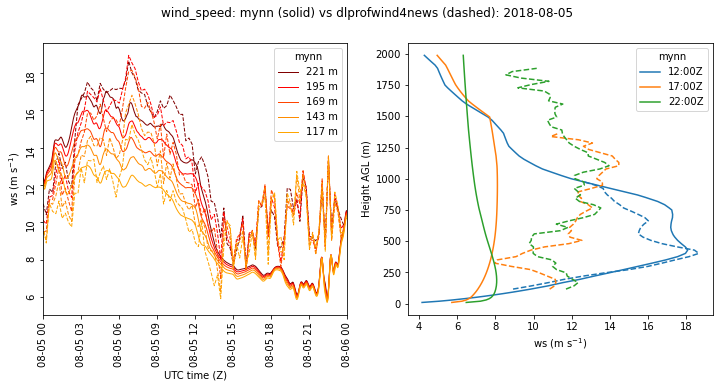

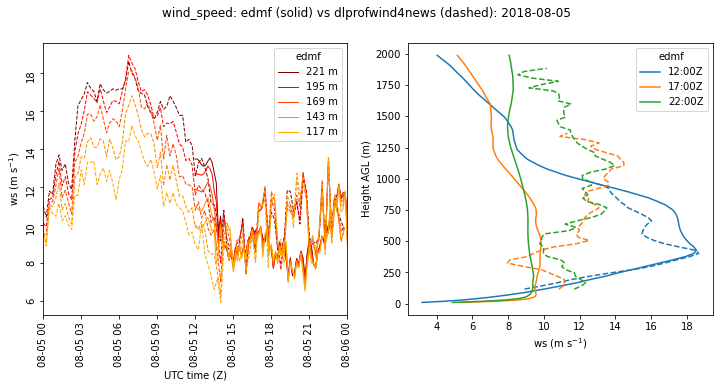

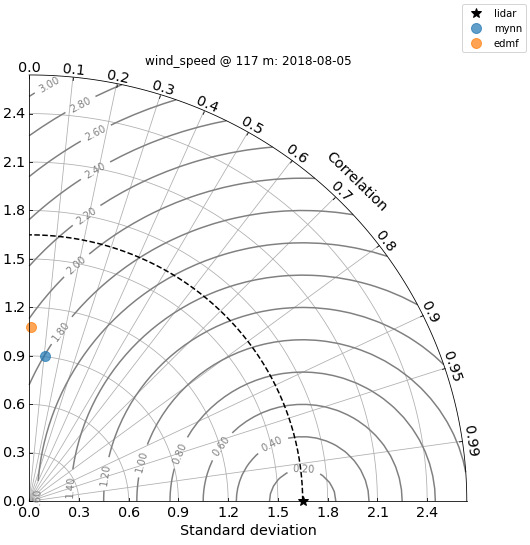

######################################################################


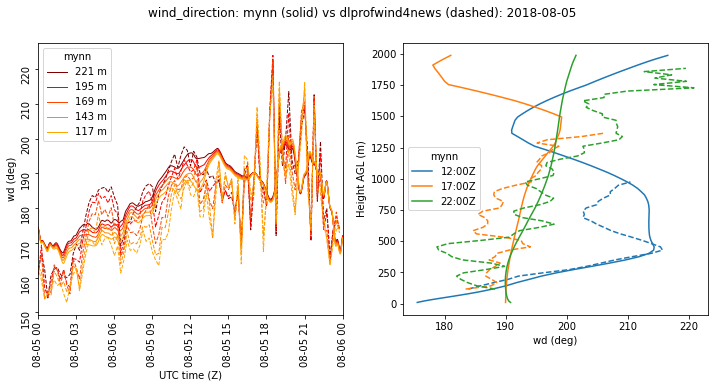

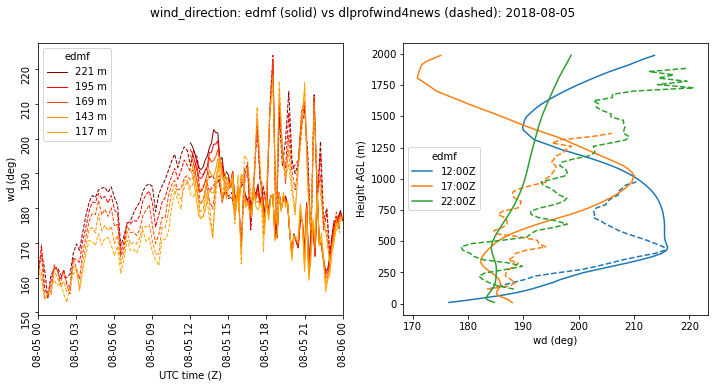

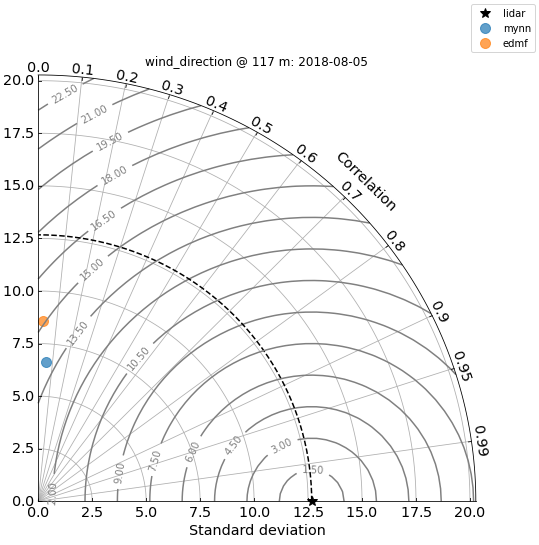

2018-08-05
dlprofwstats4news
######################################################################


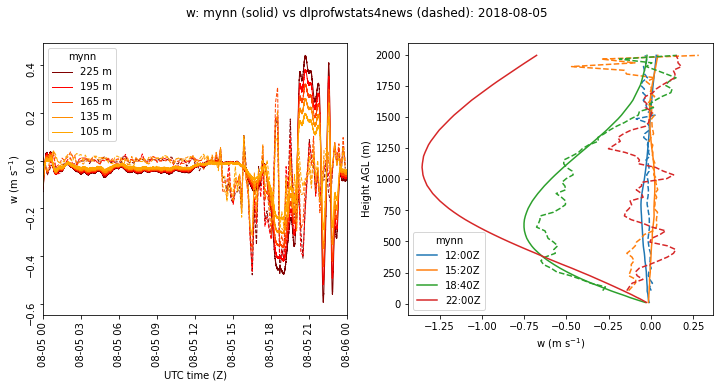

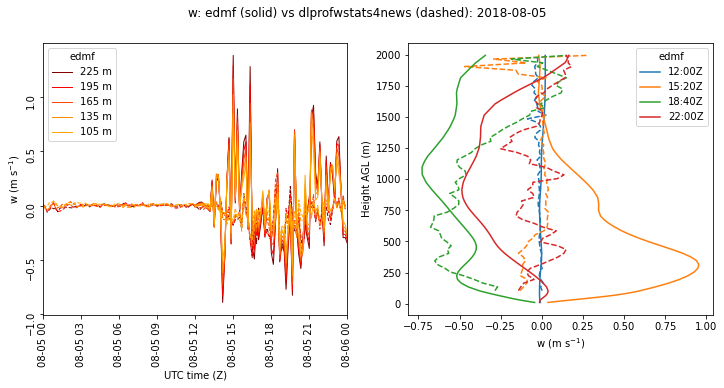

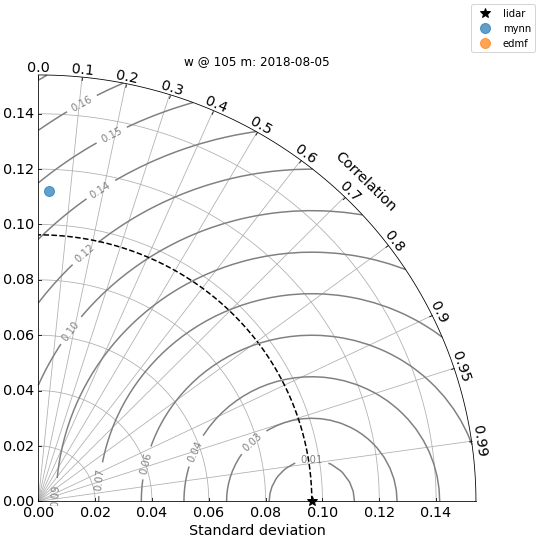

In [47]:
for col in data_dir_df.columns[:1]: 
    plot_wp_wrf_ts_taydiag(dlprofwind, col)
    plot_wp_wrf_ts_taydiag(dlprofwstats, col)

In [ ]:
dlprofwind_ncs

In [ ]:
dlprofwind

In [ ]:
plot_wp_wrf_ts_taydiag(dlprofwind, '2018-08-05')
# plot_wp_wrf_ts_taydiag(dlprofwstats, '2018-08-05')